In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import seaborn as sns

ImportError: dlopen(/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <D37BED4E-7F75-3467-A281-7E7E316989C9> /Users/jameschok/miniforge3/lib/libopenblas.0.dylib
  Reason: tried: '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/usr/local/lib/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file, not in dyld cache)

ImportError: dlopen(/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <D37BED4E-7F75-3467-A281-7E7E316989C9> /Users/jameschok/miniforge3/lib/libopenblas.0.dylib
  Reason: tried: '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/usr/local/lib/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file, not in dyld cache)

In [2]:
A = np.random.rand(5, 2)

In [3]:
from scipy.optimize import linprog

# Solve: Find x such that A x <= 1 - ε
epsilon = 1e-3
n_ineq = A.shape[0]

res = linprog(c=[0, 0], A_ub=A, b_ub=np.ones(n_ineq) - epsilon)

if res.success:
    interior_point = res.x

In [4]:
res.success

True

In [5]:
interior_point

array([0., 0.])

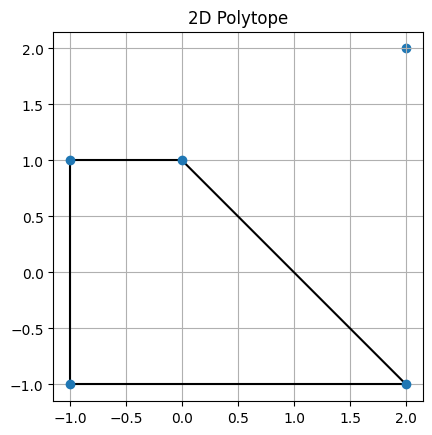

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull

# Example A: n x 2 matrix
A = np.array([
    [1, 1],
    [-1, 0],
    [0, 1],
    [0, -1]
])

b = np.ones(len(A))  # a_i x <= 1

halfspaces = np.hstack((A, -b[:, None]))

# Feasible interior point (must strictly satisfy all constraints)
interior_point = np.array([0.0, 0.0])  # Make sure this is inside the polytope

hs = HalfspaceIntersection(halfspaces, interior_point)

# Plot
fig, ax = plt.subplots()
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax.plot(points[:, 0], points[:, 1], 'k-')
ax.plot(*zip(*hs.intersections), 'o')  # Vertices
ax.set_aspect('equal')
plt.grid(True)
plt.title("2D Polytope")
plt.scatter(2, 2)
plt.show()

In [10]:
log_density = lambda x: -0.5 * torch.linalg.norm(x + 0.75, axis=-1) ** 2 \
                    * torch.linalg.norm(x - 0.25, axis=-1) ** 2

# log_density = lambda x: -2 * torch.linalg.norm(x - 2, axis=-1) ** 2
# log_density = lambda x: (0 * x).sum()

In [11]:
# particle = torch.tensor(np.array([1.8, -0.9]), requires_grad=True, dtype=torch.float64)
particle = torch.tensor(np.array([0, 0]), requires_grad=True, dtype=torch.float64)
A_torch = torch.tensor(A, dtype=torch.float64)
dt = 0.01

num_iters = 10_000
history = torch.zeros(num_iters, 2)
for i in range(num_iters):
    val = log_density(particle)
    val.backward()
    
    with torch.no_grad():
        H = (A_torch[:, :, None] * A_torch[:, None, :]) / ((1 - A_torch @ particle) ** 2)[:, None, None]
        H = H.sum(axis=0)
        
        eig_vals, eig_vecs = torch.linalg.eigh(H)
        G_inv = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        # sqrt_G_inv = eig_vecs @ torch.diag(1 / torch.sqrt(eig_vals)) @ eig_vecs.T
        sqrt_G_inv = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        
        temp_particle = particle + dt * particle.grad \
                        + np.sqrt(2 * dt) * sqrt_G_inv @ torch.randn_like(particle)
        if (A_torch @ temp_particle <= 1).all():
            particle[:] = temp_particle
        
        history[i] = particle.detach().clone()
    
    particle.grad.zero_()
    
history = history.detach().clone().numpy()

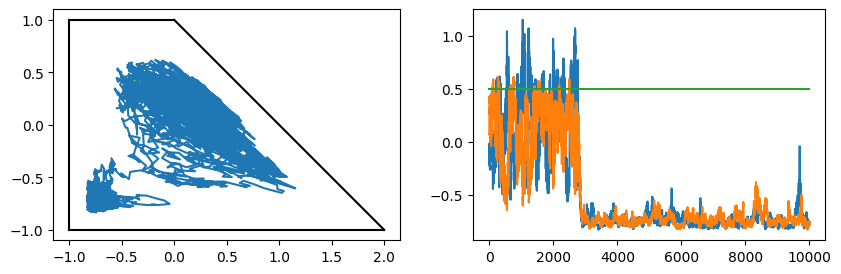

In [12]:
halfspaces = np.hstack((A, -b[:, None]))

interior_point = np.array([0.0, 0.0])

hs = HalfspaceIntersection(halfspaces, interior_point)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax[0].plot(points[:, 0], points[:, 1], 'k-')
    
ax[0].set_aspect('equal')
    
ax[0].plot(history[:, 0], history[:, 1])
ax[1].plot(history[:, 0])
ax[1].plot(history[:, 1])
# ax[1].plot([0, num_iters - 1], [0, 0])
ax[1].plot([0, num_iters - 1], [0.5, 0.5])
# ax[1].plot([0, num_iters - 1], [-0.75, -0.75])

In [273]:
history[-1]

array([ 1.0590694 , -0.06364743], dtype=float32)

In [64]:
log_density = lambda x: -1 * torch.linalg.norm(x, axis=-1) ** 2

In [92]:
# particle = torch.tensor(np.array([1.8, -0.9]), requires_grad=True, dtype=torch.float64)
particle = torch.tensor(np.array([0, 0]), requires_grad=True, dtype=torch.float64)
A_torch = torch.tensor(-A, dtype=torch.float64)
dt = 0.01

num_iters = 10_000
history = torch.zeros(num_iters, 2)
for i in range(num_iters):
    val = log_density(particle)
    val.backward()
    
    with torch.no_grad():
        A_x = A_torch / (A_torch @ particle + 1)[:, None]
        eig_vals, eig_vecs = torch.linalg.eigh(A_x.T @ A_x)
        
        G_inv = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        sqrt_G_inv = eig_vecs @ torch.diag(1 / torch.sqrt(eig_vals)) @ eig_vecs.T
        
        sigma_x = torch.diag(A_x @ G_inv @ A_x.T)
        D = -0.5 * G_inv @ A_x.T @ sigma_x
        
        temp_particle = particle + dt * (D + G_inv @ particle.grad) \
                            + np.sqrt(2 * dt) * sqrt_G_inv @ torch.randn_like(particle)
        
        # temp_particle = particle + dt * D \
        #                     + np.sqrt(2 * dt) * sqrt_G_inv @ torch.randn_like(particle)
        if (A_torch @ temp_particle <= 1).all():
            particle[:] = temp_particle
        
        history[i] = particle.detach().clone()
    
    # particle.grad.zero_()
    
history = history.detach().clone().numpy()

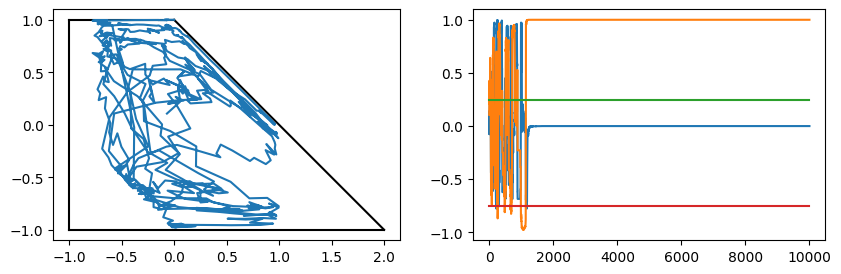

In [93]:
halfspaces = np.hstack((A, -b[:, None]))

interior_point = np.array([0.0, 0.0])

hs = HalfspaceIntersection(halfspaces, interior_point)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax[0].plot(points[:, 0], points[:, 1], 'k-')
    

temp_particle = torch.tensor([0.9, -0.9], dtype=torch.float64)
temp_particle = particle.detach().clone()
A_temp = A_torch / (1 - A_torch @ temp_particle)[:, None] ** 2
H = A_temp.T @ A_temp
H /= torch.diag(H).norm()
x = particle.detach().numpy()
# H_sqrt = sqrtm(H.detach().numpy())

# Parametrize the unit circle
# theta = np.linspace(0, 2 * np.pi, 200)
# circle = 0.000001 * np.vstack((np.cos(theta), np.sin(theta)))  # shape (2, N)

# Apply transformation to get ellipsoid
# ellipsoid = np.linalg.inv(H_sqrt) @ circle + x[:, None]  # shape (2, N)

# ax[0].plot(ellipsoid[0], ellipsoid[1])
ax[0].set_aspect('equal')
    
ax[0].plot(history[:, 0], history[:, 1])
ax[1].plot(history[:, 0])
ax[1].plot(history[:, 1])
ax[1].plot([0, num_iters - 1], [0.25, 0.25])
ax[1].plot([0, num_iters - 1], [-0.75, -0.75])

In [13]:
# plt.plot(np.linalg.norm(history - 0.25, axis=1));

# High Dim

In [225]:
log_density = lambda x: -0.5 * torch.linalg.norm(x + 0.75, axis=-1) ** 2 \
                    * torch.linalg.norm(x - 0.2, axis=-1) ** 2

In [226]:
dim = 10
A = np.concatenate([np.eye(dim), -np.eye(dim)], axis=0)
A[abs(A) < 1e-5] = 0

b = np.ones(len(A))  # a_i x <= 1

In [255]:
# particle = torch.tensor(np.array([1.8, -0.9]), requires_grad=True, dtype=torch.float64)
# particle = torch.tensor(np.zeros(dim), requires_grad=True, dtype=torch.float64)
A_torch = torch.tensor(A, dtype=torch.float64)
dt = 0.01

num_iters = 10_000
history = torch.zeros(num_iters, dim)
for i in range(num_iters):
    val = log_density(particle)
    val.backward()
    
    with torch.no_grad():
        H = (A_torch[:, :, None] * A_torch[:, None, :]) / ((1 - A_torch @ particle) ** 2)[:, None, None]
        H = H.sum(axis=0)
        
        eig_vals, eig_vecs = torch.linalg.eigh(H)
        G_inv = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        sqrt_G_inv = eig_vecs @ torch.diag(1 / torch.sqrt(eig_vals)) @ eig_vecs.T
        # sqrt_G_inv = torch.cholesky_inverse(H).T
        
        temp_particle = particle + dt * particle.grad \
                        + np.sqrt(2 * dt) * sqrt_G_inv @ torch.randn_like(particle)
        if (A_torch @ temp_particle <= 1).all():
            particle[:] = temp_particle
        else:
            print(f"RJECTION {i}")
        
        history[i] = particle.detach().clone()
    
    particle.grad.zero_()
    
history = history.detach().clone().numpy()

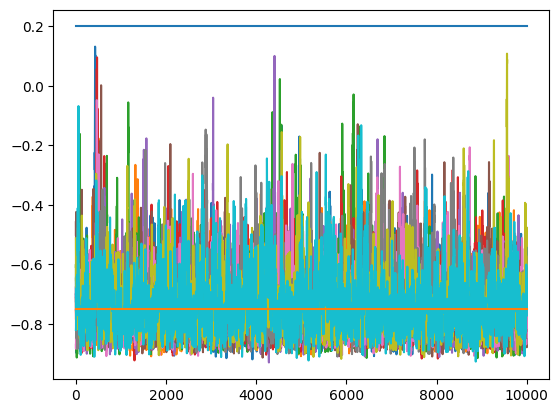

In [256]:
plt.plot(history)
plt.plot([0, num_iters - 1], [0.2, 0.2])
plt.plot([0, num_iters - 1], [-0.75, -0.75]);

In [207]:
np.linalg.norm(history + 0.95, axis=1).min()

np.float32(7.272255e-06)

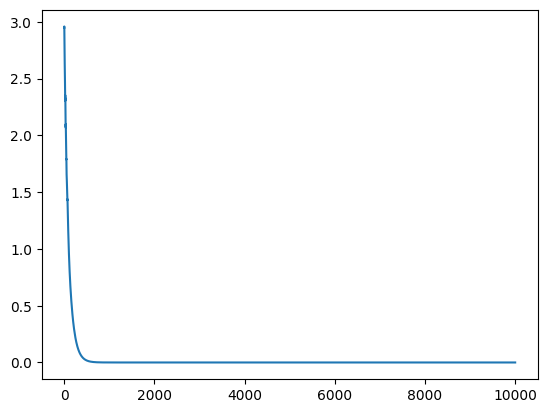

In [208]:
plt.plot(np.linalg.norm(history + 0.95, axis=1))

# Diff

In [18]:
log_density = lambda x: -0.5 * torch.linalg.norm(x + 0.75, axis=-1) ** 2 \
                    * torch.linalg.norm(x - 0.25, axis=-1) ** 2

In [40]:
# particle = torch.tensor(np.array([1.8, -0.9]), requires_grad=True, dtype=torch.float64)
particle = torch.tensor(np.array([0, 0]), requires_grad=True, dtype=torch.float64)
A_torch = torch.tensor(A, dtype=torch.float64)
dt = 0.01

num_iters = 10_000
history = torch.zeros(num_iters, 2)
for i in range(num_iters):
    val = log_density(particle)
    val += 2 * torch.log(1 - A_torch @ particle).sum()
    # val = torch.log(1 - A_torch @ particle).sum()
    val.backward()
    
    with torch.no_grad():
        # temp_particle = particle + dt * H @ particle.grad + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        # temp_particle = particle + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        temp_particle = particle + dt * particle.grad + np.sqrt(2 * dt) * torch.randn_like(particle)
        if (A_torch @ temp_particle <= 1).all():
            particle[:] = temp_particle
        
        history[i] = particle.detach().clone()
    
    particle.grad.zero_()
    
history = history.detach().clone().numpy()

In [41]:
eig_vals

tensor([ 60.8436, 469.7252], dtype=torch.float64)

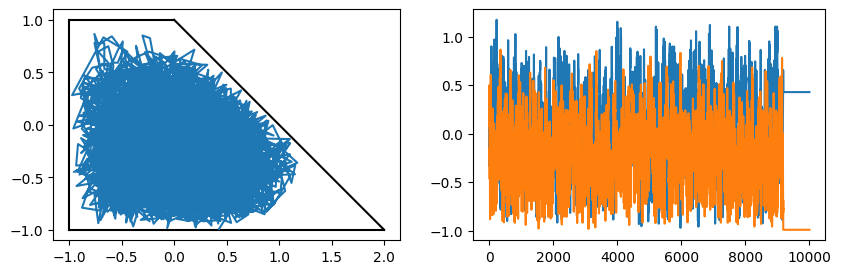

In [42]:
halfspaces = np.hstack((A, -b[:, None]))

interior_point = np.array([0.0, 0.0])

hs = HalfspaceIntersection(halfspaces, interior_point)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax[0].plot(points[:, 0], points[:, 1], 'k-')
    

# temp_particle = torch.tensor([0.9, -0.9], dtype=torch.float64)
temp_particle = particle.detach().clone()
A_temp = A_torch / (1 - A_torch @ temp_particle)[:, None] ** 2
H = A_temp.T @ A_temp
H /= torch.diag(H).norm()
x = particle.detach().numpy()
H_sqrt = sqrtm(H.detach().numpy())

# Parametrize the unit circle
theta = np.linspace(0, 2 * np.pi, 200)
circle = 0.000001 * np.vstack((np.cos(theta), np.sin(theta)))  # shape (2, N)

# Apply transformation to get ellipsoid
ellipsoid = np.linalg.inv(H_sqrt) @ circle + x[:, None]  # shape (2, N)

# ax[0].plot(ellipsoid[0], ellipsoid[1])
ax[0].set_aspect('equal')
    
ax[0].plot(history[:, 0], history[:, 1])
ax[1].plot(history[:, 0])
ax[1].plot(history[:, 1])